In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    # Process the image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

In [ ]:
# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    # Process the DCT image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed


In [ ]:
# Function to apply quantization to the DCT coefficients (block-wise)
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

# Function to dequantize the DCT coefficients (block-wise)
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct


In [ ]:
# Load the image from your Google Drive in grayscale mode (0 indicates grayscale)
image_path = "/content/download.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Pad the image to make its dimensions a multiple of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Define an 8x8 quantization matrix (for simplicity, a JPEG-like matrix)
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])


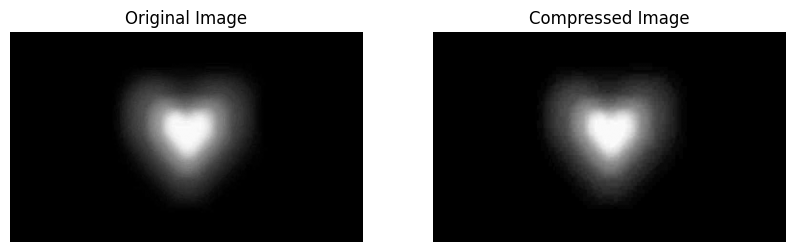

In [ ]:
# Apply block-wise DCT
dct_image = blockwise_dct(padded_image)

# Quantize the DCT coefficients block-wise
quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix)

# Dequantize to get the approximate DCT coefficients
dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix)

# Reconstruct the image using block-wise IDCT
image_reconstructed = blockwise_idct(dequantized_dct)

# Crop the reconstructed image back to the original size
image_reconstructed = image_reconstructed[:h, :w]

# Clip the values to be in the 8-bit range and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Display the original and the compressed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Save original image to check file size
cv2.imwrite("original_image.jpg", image)
original_size = os.path.getsize("original_image.jpg")

# Save compressed image to check file size
cv2.imwrite("compressed_image.jpg", image_reconstructed)
compressed_size = os.path.getsize("compressed_image.jpg")

# Print the sizes
print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size: {compressed_size / 1024:.2f} KB")

# Print memory usage (array size)
print(f"Original Image Memory: {image.nbytes / 1024:.2f} KB")
print(f"Compressed Image Memory: {image_reconstructed.nbytes / 1024:.2f} KB")


Original Image Size: 8.44 KB
Compressed Image Size: 6.83 KB
Original Image Memory: 313.24 KB
Compressed Image Memory: 313.24 KB


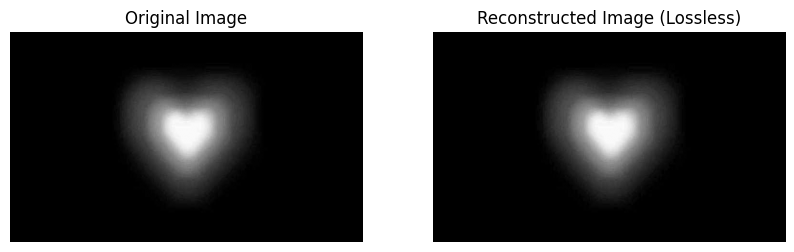

Original Image Size: 313.24 KB
Compressed Image Size (DCT representation): 1265.00 KB


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image_path = "/content/download.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Ensure dimensions are multiples of 8
h, w = image.shape
new_h = (h + 7) // 8 * 8
new_w = (w + 7) // 8 * 8
padded_image = cv2.copyMakeBorder(image, 0, new_h - h, 0, new_w - w, cv2.BORDER_CONSTANT, value=0)

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_image[i:i+block_size, j:j+block_size] = cv2.dct(np.float32(block))  # Apply DCT

    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i+block_size, j:j+block_size]
            image_reconstructed[i:i+block_size, j:j+block_size] = cv2.idct(block)  # Apply Inverse DCT

    return image_reconstructed

# Apply lossless DCT and IDCT
dct_image = blockwise_dct(padded_image)
image_reconstructed = blockwise_idct(dct_image)

# Crop the reconstructed image to the original size
image_reconstructed = image_reconstructed[:h, :w]

# Clip values to 8-bit range and convert to uint8
image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Reconstructed Image (Lossless)')
plt.axis('off')

plt.show()

# Print size of original and compressed images
original_size = image.nbytes
compressed_size = dct_image.nbytes  # DCT representation in float32 takes more space

print(f"Original Image Size: {original_size / 1024:.2f} KB")
print(f"Compressed Image Size (DCT representation): {compressed_size / 1024:.2f} KB")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape to match CNN input (28x28 images with 1 channel)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), strides=2, activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), strides=2, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.2)


Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6788 - loss: 1.1095 - val_accuracy: 0.9272 - val_loss: 0.2454
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9323 - loss: 0.2244 - val_accuracy: 0.9542 - val_loss: 0.1569
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9537 - loss: 0.1525 - val_accuracy: 0.9581 - val_loss: 0.1424
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9616 - loss: 0.1249 - val_accuracy: 0.9643 - val_loss: 0.1130
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9651 - loss: 0.1096 - val_accuracy: 0.9692 - val_loss: 0.1047
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9712 - loss: 0.0908 - val_accuracy: 0.9709 - val_loss: 0.0947
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9729 - loss: 0.0861 - val_accuracy: 0.9711 - val_loss: 0.0887
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9774 - loss: 0.0724 - val_a

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


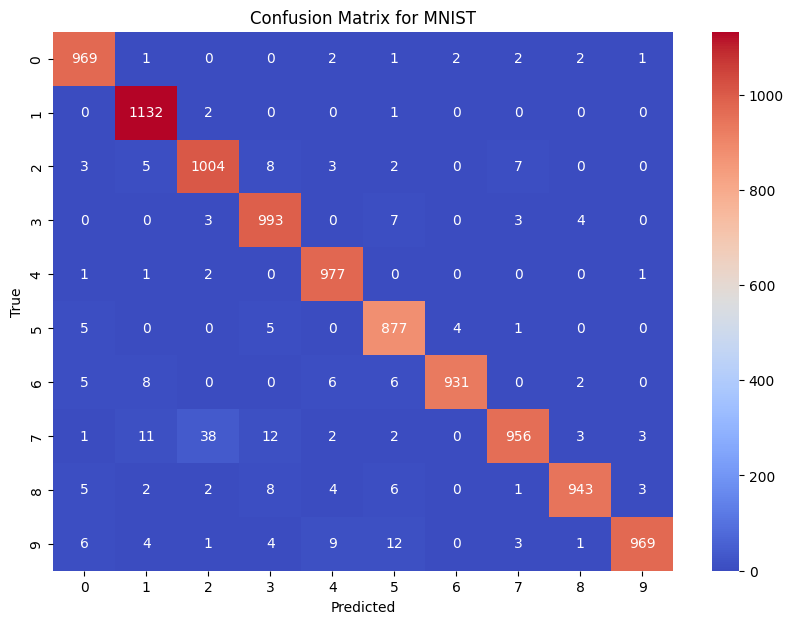

AUC Score: 0.9996


In [ ]:
# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Model Evaluation
accuracy = np.mean(y_pred_classes == y_true)
precision = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['recall']
f1_score = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['f1-score']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MNIST')
plt.show()

# ROC Curve & AUC
auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 211ms/step - accuracy: 0.2808 - loss: 1.9510 - val_accuracy: 0.4721 - val_loss: 1.4470
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 172ms/step - accuracy: 0.5045 - loss: 1.3794 - val_accuracy: 0.5618 - val_loss: 1.2517
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 178ms/step - accuracy: 0.5656 - loss: 1.2312 - val_accuracy: 0.5718 - val_loss: 1.2054
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.6132 - loss: 1.1007 - val_accuracy: 0.6163 - val_loss: 1.0946
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 173ms/step - accuracy: 0.6393 - loss: 1.0311 - val_accuracy: 0.6434 - val_loss: 1.0344
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.6703 - loss: 0.9448 - val_accuracy: 0.6528 - val_loss: 1.0044
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 177ms/step - accuracy: 0.6958 - loss: 0.8773 - val_accuracy: 0.6726 - val_loss: 0.9520
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.7106 - loss: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


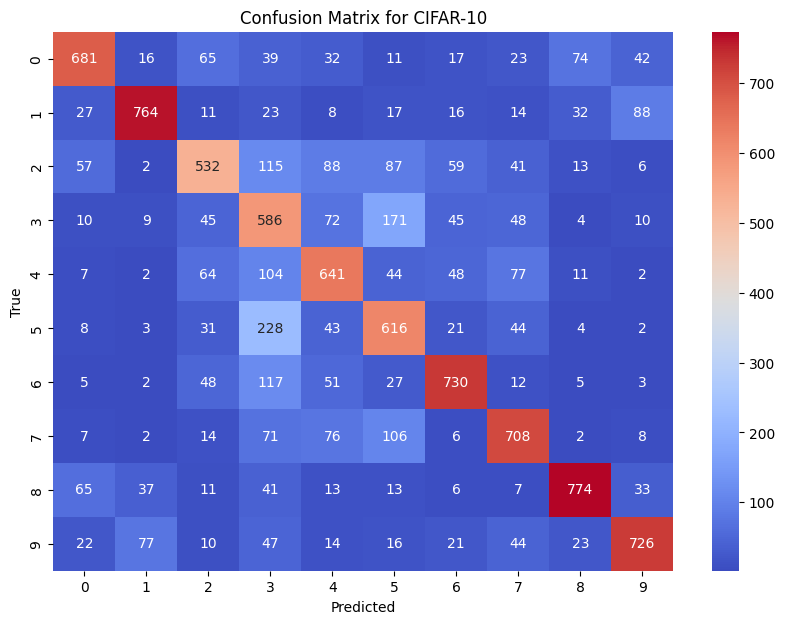

AUC Score: 0.9489


In [ ]:

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = np.mean(y_pred_classes == y_true)
precision = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['recall']
f1_score = classification_report(y_true, y_pred_classes, output_dict=True)['weighted avg']['f1-score']


conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()


auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")
